# Pawpularity 목적과 데이터 설명

## Why this competition?
As evident from the problem statement, this competition presents an interesting challenge for a good cause.  
Also (if successful) the solution can be adapted into tools that will can shelters and rescuers around the world to improve the appeal of their pet profiles, automatically enhancing photo quality and consequently helping animals find a suitable home much faster.

## Expected Outcome
Given a photo a pet animal and some basic information about the photo as dense features, we should be able to estimate the 'pawpularity' score of the pet.

## Data Description
Image data is stored in a jpg image format in training folder and the dense features and target scores are mentioned in the `train.csv` file where the Id of each row corresponds to an unique image in the training folder.
There are also some basic info on the photograph as dense features on the `train.csv` file.

## Grading Metric (평가는 RMSE)
Submissions are evaluated on **RMSE** between the predicted value and the observed target.

## Problem Category
From the data and objective its is evident that this is a **Regression Problem** in the Computer Vision domain.

# About This Notebook:-
* Pytorch를 사용한 전이학습을 시도하며 이미지의 특징(Feature을 찾기)(RGB 채널?)

* 사용모델은 Transfomer 기반의 **vit_large_patch32_384** 을 사용. 나는 GPU가 부족하여 **vit_small_patch32_384**를 사용.
* 참조 [this link](https://www.kaggle.com/c/petfinder-pawpularity-score/discussion/275094) 

# Get GPU Info

In [ ]:
!nvidia-smi # GPU 확인

Mon Oct 25 00:30:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Installations

In [ ]:
# Image를 분석할 때사용하는 라이브러리 다운(각각의 의미는 찾아봐야함.)

!pip install -qq timm                     # Ross Wightman이 만든 딥러닝 라이브러리...Keras와 비슷?
!pip install -qq albumentations==1.0.3    # 이미지 증강을 위한 라이브러리. 색을 보정하여 이미지를 늘림.
!pip install -qq grad-cam                 # 사진에서 특정(중요한 부분)부분을 Heatmap처럼 강조할 수 있음.
!pip install -qq ttach                    # 테스트에 대한 이미지 테스트 시간 증대...(여기서 에러가 나는 것 같음.)

     |████████████████████████████████| 376 kB 5.3 MB/s 
     |████████████████████████████████| 98 kB 3.2 MB/s 
     |████████████████████████████████| 47.6 MB 37 kB/s 
     |████████████████████████████████| 1.7 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
# Asthetics
import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

# General
from tqdm.auto import tqdm 
from collections import defaultdict
import pandas as pd
import numpy as np
import os
import random
import gc            # 가비지 수거기? 메모리 관리?
import cv2           # OpenCV
import glob
gc.enable()
pd.set_option('display.max_columns', None)

# Visialisation
import matplotlib.pyplot as plt
%matplotlib inline

# Image Aug
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

# Deep Learning
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, OneCycleLR, CosineAnnealingLR
import torch
import torchvision
import timm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#Metrics
from sklearn.metrics import mean_squared_error

# Random Seed Initialize
RANDOM_SEED = 42

def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

# Device Optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(f'Using device: {device}')

Using device: cuda


In [ ]:
import os
os.chdir("/content/drive/MyDrive/0_Coding/K-digital/pj2")

In [ ]:
csv_dir = './'
train_dir = './train/'
test_dir = './test/'

train_file_path = './train_5folds.csv'              # 사전에 Kfold가 만들어져 있음.
sample_sub_file_path = os.path.join(csv_dir, 'sample_submission.csv')

print(f'Train file: {train_file_path}')
print(f'Train file: {sample_sub_file_path}')

Train file: ./train_5folds.csv
Train file: ./sample_submission.csv


In [ ]:
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(sample_sub_file_path)

In [ ]:
def return_filpath(name, folder=train_dir):
    path = os.path.join(folder, f'{name}.jpg')
    return path

In [ ]:
train_df['image_path'] = train_df['Id'].apply(lambda x: return_filpath(x))
test_df['image_path'] = test_df['Id'].apply(lambda x: return_filpath(x, folder=test_dir))

In [ ]:
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,kfold,image_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,0,./train/0007de18844b0dbbb5e1f607da0606e0.jpg
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,2,./train/0009c66b9439883ba2750fb825e1d7db.jpg
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,0,./train/0013fd999caf9a3efe1352ca1b0d937e.jpg
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,3,./train/0018df346ac9c1d8413cfcc888ca8246.jpg
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,4,./train/001dc955e10590d3ca4673f034feeef2.jpg


In [ ]:
test_df.head()

,Id,Pawpularity,image_path
0,4128bae22183829d2b5fea10effdb0c3,67.75,./test/4128bae22183829d2b5fea10effdb0c3.jpg
1,43a2262d7738e3d420d453815151079e,59.15,./test/43a2262d7738e3d420d453815151079e.jpg
2,4e429cead1848a298432a0acad014c9d,20.02,./test/4e429cead1848a298432a0acad014c9d.jpg
3,80bc3ccafcc51b66303c2c263aa38486,94.53,./test/80bc3ccafcc51b66303c2c263aa38486.jpg
4,8f49844c382931444e68dffbe20228f4,89.82,./test/8f49844c382931444e68dffbe20228f4.jpg


In [ ]:
target = ['Pawpularity']
not_features = ['Id', 'kfold', 'image_path', 'Pawpularity']
cols = list(train_df.columns)
features = [feat for feat in cols if feat not in not_features]
print(features)

['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']


# CFG

In [ ]:
TRAIN_FOLDS = [0, 1, 2, 3, 4]

In [ ]:
params = {
    'model': 'vit_small_patch32_384',
    'dense_features': features,
    'pretrained': True,
    'inp_channels': 3,
    'im_size': 384,
    'device': device,
    'lr': 1e-5,
    'weight_decay': 1e-6,
    'batch_size': 32,
    'num_workers' : 0,
    'epochs': 10,
    'out_features': 1,
    'dropout': 0.2,
    'num_fold': len(TRAIN_FOLDS),
    'mixup': False,
    'mixup_alpha': 1.0,
    'scheduler_name': 'CosineAnnealingWarmRestarts',
    'T_0': 5,
    'T_max': 5,
    'T_mult': 1,
    'min_lr': 1e-7,
    'max_lr': 1e-4
}

# Augmentations
- 하나의 이미지를 다양한 보정효과로 증강시킴.


There a well known concept called **image augmentations** in CNN. What augmentation generally does is, it artificially increases the dataset size by subtly modifying the existing images to create new ones (while training). One added advantage of this is:- The model becomes more generalized and focuses to finding features and representations rather than completely overfitting to the training data. It also sometimes helps the model train on more noisy data as compared to conventional methods.  

Example:-  
![](https://www.researchgate.net/publication/319413978/figure/fig2/AS:533727585333249@1504261980375/Data-augmentation-using-semantic-preserving-transformation-for-SBIR.png)  
Source:- https://www.researchgate.net/publication/319413978/figure/fig2/AS:533727585333249@1504261980375/Data-augmentation-using-semantic-preserving-transformation-for-SBIR.png

One of the most popular image augmentation libraries is **Albumentations**. It has an extensive list of image augmentations, the full list can be found in their [documentation](https://albumentations.ai/docs/).  

*Tip:- Not all augmentations are applicable in all conditions. It really depends on the dataset and the problem. Example:- If your task is to identify if a person is standing or sleeping, applying a rotational augmentation can make the model worse.*  

With that in mind, let's define our augmentations:-

## 1. Train Augmentations

In [ ]:
def get_train_transforms(DIM = params['im_size']): 
    return albumentations.Compose(
        [
            albumentations.Resize(DIM,DIM),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Rotate(limit=180, p=0.7),
            albumentations.ShiftScaleRotate(
                shift_limit = 0.1, scale_limit=0.1, rotate_limit=45, p=0.5
            ),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, sat_shift_limit=0.2,
                val_shift_limit=0.2, p=0.5
            ),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1, 0.1),
                contrast_limit=(-0.1, 0.1), p=0.5
            ),
            ToTensorV2(p=1.0),
        ]
    )

## 2. Mixup

In [ ]:
def mixup_data(x, z, y, params):
    if params['mixup_alpha'] > 0:
        lam = np.random.beta(
            params['mixup_alpha'], params['mixup_alpha']
        )
    else:
        lam = 1

    batch_size = x.size()[0]
    if params['device'].type == 'cuda':
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_z = lam * z + (1 - lam) * z[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, mixed_z, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

## 3. Valid Augmentations

In [ ]:
def get_valid_transforms(DIM = params['im_size']):
    return albumentations.Compose(
        [
          albumentations.Resize(DIM,DIM),
          albumentations.Normalize(
              mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225],
          ),
          ToTensorV2(p=1.0)
        ]
    )

# Dataset

In [ ]:
class CuteDataset(Dataset):
    def __init__(self, images_filepaths, dense_features, targets, transform=None):
        self.images_filepaths = images_filepaths
        self.dense_features = dense_features
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            image = self.transform(image=image)['image']
        
        dense = self.dense_features[idx, :]
        label = torch.tensor(self.targets[idx]).float()
        return image, dense, label

## 1. Visualize Some Examples

In [ ]:
X_train = train_df['image_path']
X_train_dense = train_df[params['dense_features']]
y_train = train_df['Pawpularity']
train_dataset = CuteDataset(
    images_filepaths=X_train.values,
    dense_features=X_train_dense.values,
    targets=y_train.values,
    transform=get_train_transforms()
)

In [ ]:
def show_image(train_dataset=train_dataset, inline=4):
    plt.figure(figsize=(20,10))
    for i in range(inline):
        rand = random.randint(0, len(train_dataset))
        image, dense, label = train_dataset[rand]
        plt.subplot(1, inline, i%inline +1)
        plt.axis('off')
        plt.imshow(image.permute(2, 1, 0))
        plt.title(f'Pawpularity: {label}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


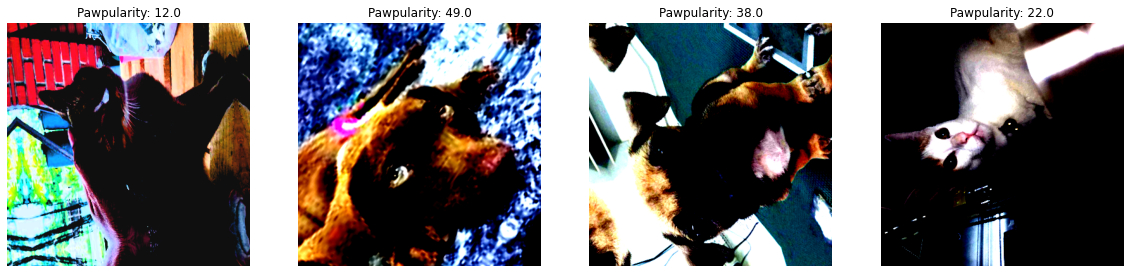

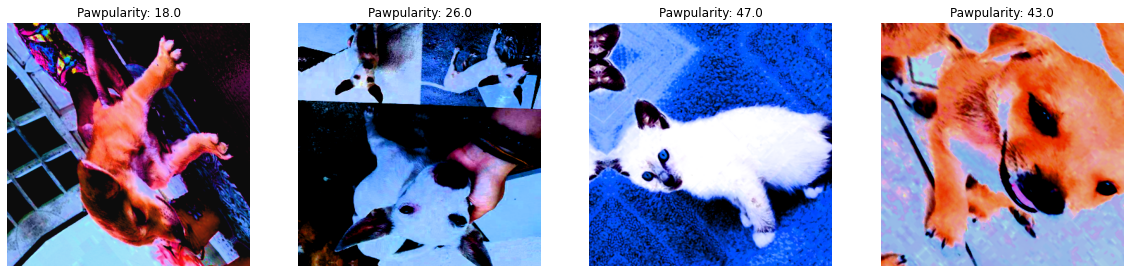

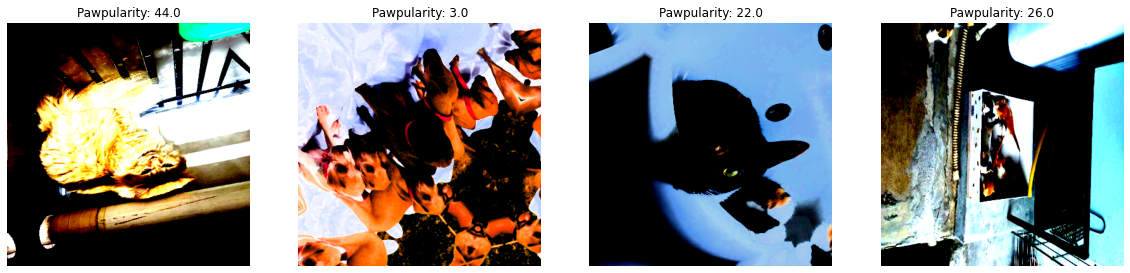

In [ ]:
for i in range(3):
    show_image(inline=4)

In [ ]:
del X_train, X_train_dense, y_train, train_dataset

# Metrics

In [ ]:
def usr_rmse_score(output, target):
    y_pred = torch.sigmoid(output).cpu()
    y_pred = y_pred.detach().numpy()*100
    target = target.cpu()*100
    
    return mean_squared_error(target, y_pred, squared=False)

In [ ]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

# Scheduler

Scheduler is essentially an function that changes our learning rate over epochs/steps. But why do we need to do that?
1. The first reason is that our network may become stuck in either saddle points or local minima, and the low learning rate may not be sufficient to break out of the area and descend into areas of the loss landscape with lower loss.
2. Secondly, our model and optimizer may be very sensitive to our initial learning rate choice. If we make a poor initial choice in learning rate, our model may be stuck from the very start.

Instead, we can use Schedulers and specifically Cyclical Learning Rates(CLR) to oscillate our learning rate between upper and lower bounds, enabling us to:
* Have more freedom in our initial learning rate choices.
* Break out of saddle points and local minima.

In practice, using CLRs leads to far fewer learning rate tuning experiments along with near identical accuracy to exhaustive hyperparameter tuning.

In [ ]:
# scheduler - step과 epoch을 지나가면서 learning rate를 변결할 수 있는것. 
# learning rate를 변경하면서 overfitting, underfitting 등의 문제점을 방지할 수 있음.

def get_scheduler(optimizer, scheduler_params=params):
    if scheduler_params['scheduler_name'] == 'CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(
            optimizer,
            T_0=scheduler_params['T_0'],
            eta_min=scheduler_params['min_lr'],
            last_epoch=-1
        )
    elif scheduler_params['scheduler_name'] == 'OneCycleLR':
        scheduler = OneCycleLR(
            optimizer,
            max_lr=scheduler_params['max_lr'],
            steps_per_epoch=int(((scheduler_params['num_fold']-1) * train_df.shape[0]) / (scheduler_params['num_fold'] * scheduler_params['batch_size'])) + 1,
            epochs=scheduler_params['epochs'],
        )

    elif scheduler_params['scheduler_name'] == 'CosineAnnealingLR':
        scheduler = CosineAnnealingLR(
            optimizer,
            T_max=scheduler_params['T_max'],
            eta_min=scheduler_params['min_lr'],
            last_epoch=-1
        )
    return scheduler

# CNN Model

We will inherit from the nn.Module class to define our model. This is a easy as well as effective way of defining the model as it allows very granular control over the complete NN. We are not using the full capability of it here since it is a starter model, but practicing similar definitions will help if/when you decide to play around a little more with the NN layers and functions.  

Also we are using timm for instancing a pre-trained model.  
The complete list of Pytorch pre-trained image models through timm can be found [here](https://rwightman.github.io/pytorch-image-models/)  

In [ ]:
class PetNet(nn.Module):
    def __init__(self, model_name=params['model'], out_features=params['out_features'], inp_channels=params['inp_channels'],
                 pretrained=params['pretrained'], num_dense=len(params['dense_features'])):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=inp_channels)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, 128)                            # model head (feature 개수 x 128)
        self.fc = nn.Sequential(
            nn.Linear(128 + num_dense, 64),                                     # 128 에 feature 개수만큼 num_dense를 더함.
            nn.ReLU(),                                                          # ReLu - Activation Function
            nn.Linear(64, out_features)
        )
        self.dropout = nn.Dropout(params['dropout'])
    
    def forward(self, image, dense):
        embeddings = self.model(image)
        x = self.dropout(embeddings)
        x = torch.cat([x, dense], dim=1)
        output = self.fc(x)
        return output

# Train and Validation Functions

## 1. Train Function

In [ ]:
def train_fn(train_loader, model, criterion, optimizer, epoch, params, scheduler=None):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    
    for i, (images, dense, target) in enumerate(stream, start=1):
        if params['mixup']:
            images, dense, target_a, target_b, lam = mixup_data(images, dense, target.view(-1, 1), params)
            images = images.to(params['device'], dtype=torch.float)
            dense = dense.to(params['device'], dtype=torch.float)
            target_a = target_a.to(params['device'], dtype=torch.float)
            target_b = target_b.to(params['device'], dtype=torch.float)
        else:
            images = images.to(params['device'], non_blocking=True)
            dense = dense.to(params['device'], non_blocking=True)
            target = target.to(params['device'], non_blocking=True).float().view(-1, 1)
            
        output = model(images, dense)
        
        if params['mixup']:
            loss = mixup_criterion(criterion, output, target_a, target_b, lam)
        else:
            loss = criterion(output, target)
            
        rmse_score = usr_rmse_score(output, target)
        metric_monitor.update('Loss', loss.item())
        metric_monitor.update('RMSE', rmse_score)
        loss.backward()
        optimizer.step()
            
        if scheduler is not None:
            scheduler.step()
        
        optimizer.zero_grad()
        stream.set_description(f"Epoch: {epoch:02}. Train. {metric_monitor}")

## 2. Validate Function

In [ ]:
def validate_fn(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    final_targets = []
    final_outputs = []
    with torch.no_grad():
        for i, (images, dense, target) in enumerate(stream, start=1):
            images = images.to(params['device'], non_blocking=True)
            dense = dense.to(params['device'], non_blocking=True)
            target = target.to(params['device'], non_blocking=True).float().view(-1, 1)
            output = model(images, dense)
            loss = criterion(output, target)
            rmse_score = usr_rmse_score(output, target)
            metric_monitor.update('Loss', loss.item())
            metric_monitor.update('RMSE', rmse_score)
            stream.set_description(f"Epoch: {epoch:02}. Valid. {metric_monitor}")
            
            targets = (target.detach().cpu().numpy()*100).tolist()
            outputs = (torch.sigmoid(output).detach().cpu().numpy()*100).tolist()
            
            final_targets.extend(targets)
            final_outputs.extend(outputs)
    return final_outputs, final_targets

# Run

In [ ]:
best_models_of_each_fold = []
rmse_tracker = []

In [ ]:
for fold in TRAIN_FOLDS:
    print(''.join(['#']*50))
    print(f"{''.join(['=']*15)} TRAINING FOLD: {fold+1}/{train_df['kfold'].nunique()} {''.join(['=']*15)}")
    # Data Split to train and Validation
    train = train_df[train_df['kfold'] != fold]
    valid = train_df[train_df['kfold'] == fold]
    
    X_train = train['image_path']
    X_train_dense = train[params['dense_features']]
    y_train = train['Pawpularity']/100
    X_valid = valid['image_path']
    X_valid_dense = valid[params['dense_features']]
    y_valid = valid['Pawpularity']/100
    
    # Pytorch Dataset Creation
    train_dataset = CuteDataset(
        images_filepaths=X_train.values,
        dense_features=X_train_dense.values,
        targets=y_train.values,
        transform=get_train_transforms()
    )

    valid_dataset = CuteDataset(
        images_filepaths=X_valid.values,
        dense_features=X_valid_dense.values,
        targets=y_valid.values,
        transform=get_valid_transforms()
    )
    
    # Pytorch Dataloader creation
    train_loader = DataLoader(
        train_dataset, batch_size=params['batch_size'], shuffle=True,
        num_workers=params['num_workers'], pin_memory=True
        )

    val_loader = DataLoader(
        valid_dataset, batch_size=params['batch_size'], shuffle=False,
        num_workers=params['num_workers'], pin_memory=True
        )
    
    # Model, cost function and optimizer instancing
    model = PetNet()
    model = model.to(params['device'])
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=params['lr'],
                                  weight_decay=params['weight_decay'],
                                  amsgrad=False)
    scheduler = get_scheduler(optimizer)
    
    # Training and Validation Loop
    best_rmse = np.inf
    best_epoch = np.inf
    best_model_name = None
    for epoch in range(1, params['epochs'] + 1):
        train_fn(train_loader, model, criterion, optimizer, epoch, params, scheduler)
        predictions, valid_targets = validate_fn(val_loader, model, criterion, epoch, params)
        rmse = round(mean_squared_error(valid_targets, predictions, squared=False), 3)
        if rmse < best_rmse:
            best_rmse = rmse
            best_epoch = epoch
            if best_model_name is not None:
                os.remove(best_model_name)
            torch.save(model.state_dict(),
                       f"{params['model']}_{epoch}_epoch_f{fold+1}_{rmse}_rmse.pth")
            best_model_name = f"{params['model']}_{epoch}_epoch_f{fold+1}_{rmse}_rmse.pth"

    # Print summary of this fold
    print('')
    print(f'The best RMSE: {best_rmse} for fold {fold+1} was achieved on epoch: {best_epoch}.')
    print(f'The Best saved model is: {best_model_name}')
    best_models_of_each_fold.append(best_model_name)
    rmse_tracker.append(best_rmse)
    print(''.join(['#']*50))
    del model
    gc.collect()
    torch.cuda.empty_cache()

print('')
print(f'Average RMSE of all folds: {round(np.mean(rmse_tracker), 4)}')

##################################################
=============== TRAINING FOLD: 1/5 ===============


  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]


The best RMSE: 18.696 for fold 1 was achieved on epoch: 10.
The Best saved model is: vit_small_patch32_384_10_epoch_f1_18.696_rmse.pth
##################################################
##################################################
=============== TRAINING FOLD: 2/5 ===============


  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]


The best RMSE: 19.002 for fold 2 was achieved on epoch: 5.
The Best saved model is: vit_small_patch32_384_5_epoch_f2_19.002_rmse.pth
##################################################
##################################################
=============== TRAINING FOLD: 3/5 ===============


  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]


The best RMSE: 18.693 for fold 3 was achieved on epoch: 8.
The Best saved model is: vit_small_patch32_384_8_epoch_f3_18.693_rmse.pth
##################################################
##################################################
=============== TRAINING FOLD: 4/5 ===============


  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]


The best RMSE: 17.978 for fold 4 was achieved on epoch: 8.
The Best saved model is: vit_small_patch32_384_8_epoch_f4_17.978_rmse.pth
##################################################
##################################################
=============== TRAINING FOLD: 5/5 ===============


  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]


The best RMSE: 18.583 for fold 5 was achieved on epoch: 9.
The Best saved model is: vit_small_patch32_384_9_epoch_f5_18.583_rmse.pth
##################################################

Average RMSE of all folds: 18.5904


In [ ]:
for i, name in enumerate(best_models_of_each_fold):
    print(f'Best model of fold {i+1}: {name}')

Best model of fold 1: vit_small_patch32_384_10_epoch_f1_18.696_rmse.pth
Best model of fold 2: vit_small_patch32_384_5_epoch_f2_19.002_rmse.pth
Best model of fold 3: vit_small_patch32_384_8_epoch_f3_18.693_rmse.pth
Best model of fold 4: vit_small_patch32_384_8_epoch_f4_17.978_rmse.pth
Best model of fold 5: vit_small_patch32_384_9_epoch_f5_18.583_rmse.pth


In [ ]:
!pwd

/content
